In [14]:
%matplotlib inline 
import numpy as np
from matplotlib import pyplot as plt

### Utility functions

In [15]:
def obj(w):
    ## calculates the obj functions
    r = X*w-y;
    return np.sum(np.multiply(r,r))/2 +  lamda * np.sum(np.abs(w))

## Data

In [16]:
np.random.seed(50)

N = 100
dim = 30
lamda = 1/np.sqrt(N);

w = np.zeros(dim)
n_nonzero = 15
w[np.random.choice(range(dim), n_nonzero, False)] = np.random.randn(n_nonzero)
w = np.matrix(w.reshape(-1, 1))

X = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N))
y = X*w

Our objective function of interest is:
$$\frac{1}{2} \| Xw - y \|^2 + \lambda |w|_1 $$

In the cell above, the variables X, y, w and lamda corresponds to $X, y, w$ and $\lambda$ in the equation above.

In [17]:
opt = obj(w)
print('Optimal Objective Function Value: ', opt)

Optimal Objective Function Value:  1.3043384900597284


## Optimal Value using SKLearn

In [18]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=lamda / N, fit_intercept = False)
clf.fit(X, y)

Lasso(alpha=0.001, fit_intercept=False)

In [19]:
print('SKLearn obj val: ', obj(clf.coef_.reshape(-1, 1)) )

SKLearn obj val:  1.303641803846212


## Proximal Gradient

In [20]:
max_iter = 100 # max number of iterations of proximal gradient method

In [21]:
alpha_array = np.logspace(-5, -2, num = 10, base = 10.0) #range over which you search hyperparam

In [22]:
def g_prox(x, step_size):
    """
    L1 regularization
    """
    return np.fmax(x - step_size * alpha, 0) - np.fmax(- x - step_size * alpha, 0)

In [23]:
def f_prime(x, b, y):
    return x.T @ (x @ b - y)

In [24]:
## Proximal Gadient 

obj_pg = {} #stores obj function value as a function of iteration for each alpha
w_pg = {} #stores the final weight vector learned for each alpha

tol = 0.01

for alpha in alpha_array:
    print('Alpha: ', alpha)
    
    w_pg[alpha] = np.matrix([0.0]*dim).T
    obj_pg[alpha] = []
    
    
    for t in range(0, max_iter):
        obj_val = obj(w_pg[alpha])
        obj_pg[alpha].append(obj_val.item())
        
        ## fill in your code
        ## be sure to include your stopping condition
        grad_fk = f_prime(X, w_pg[alpha], y)
        wk_grad = w_pg[alpha] - alpha * grad_fk
        prx = g_prox(wk_grad, alpha)
        w_pg[alpha] = prx
        
        sign = np.zeros(shape=(len(prx), 1))
        for elem in range(len(prx)):
            if prx[elem] > 0:
                sign[elem] = 1
            elif prx[elem] < 0:
                sign[elem] = -1
        if np.add(grad_fk, lamda * sign).all() < tol:
            print("Achieved relative tolerance at iteration %s" % t)
            break

        if (t%10==0):
            print('iter= {},\tobjective= {:3f}'.format(t, obj_val.item()))

Alpha:  1e-05
iter= 0,	objective= 831.575313
iter= 10,	objective= 807.827723
iter= 20,	objective= 784.858060
iter= 30,	objective= 762.639041
iter= 40,	objective= 741.144378
iter= 50,	objective= 720.348736
iter= 60,	objective= 700.227700
iter= 70,	objective= 680.757744
iter= 80,	objective= 661.916192
iter= 90,	objective= 643.681189
Alpha:  2.1544346900318823e-05
iter= 0,	objective= 831.575313
iter= 10,	objective= 781.331858
iter= 20,	objective= 734.561707
iter= 30,	objective= 691.008037
iter= 40,	objective= 650.433717
iter= 50,	objective= 612.619760
iter= 60,	objective= 577.363910
iter= 70,	objective= 544.479326
iter= 80,	objective= 513.793383
iter= 90,	objective= 485.146564
Alpha:  4.641588833612782e-05
iter= 0,	objective= 831.575313
iter= 10,	objective= 727.433455
iter= 20,	objective= 638.133069
iter= 30,	objective= 561.416201
iter= 40,	objective= 495.380805
iter= 50,	objective= 438.423409
iter= 60,	objective= 389.191302
iter= 70,	objective= 346.542337
iter= 80,	objective= 309.510795


Text(0, 0.5, 'Objective error')

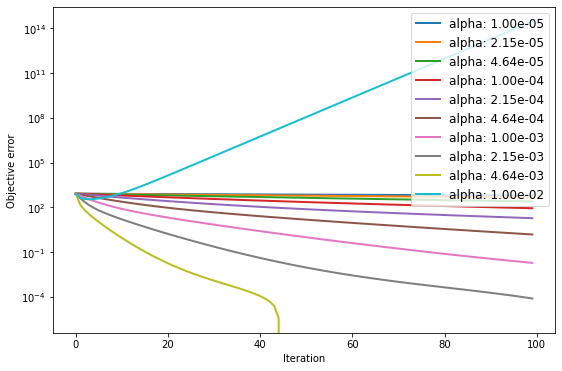

In [25]:
## Plot objective error vs. iteration (log scale)

fig, ax = plt.subplots(figsize = (9, 6))

for alpha in alpha_array:
    plt.semilogy(np.array(obj_pg[alpha])-opt,  linewidth = 2, label = 'alpha: '+'{:.2e}'.format(alpha) )
plt.legend(prop={'size':12})
plt.xlabel('Iteration')
plt.ylabel('Objective error')

From this plot, we can see as alpha remains at a very small value, the algorithm converges slowly and the objective error can hardly decrease as the iteration number increases. When alpha/step size becomes larger, the error decreases faster or the algorithm converges faster as iteration number increases. However, if we have too large a step size, i.e. in this case when alpha=0.01, the algorithm diverges.

## Visualize Coefficients

pick the coefficient corresponding to alpha value with the minimum objective function value

In [34]:
min_obj= np.inf
min_alpha = None

In [35]:
for alpha in alpha_array:
    if obj_pg[alpha][-1] < min_obj:
        min_alpha = alpha
        min_obj = obj_pg[alpha][-1]

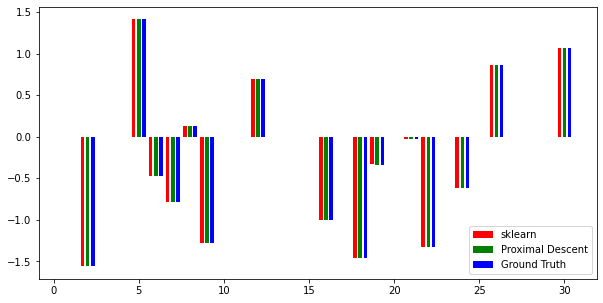

In [36]:
plt.figure(figsize = (10, 5))

ax = plt.subplot(111)

x = np.arange(1, dim+1)

ax.bar(x-0.3, clf.coef_, width=0.2, color='r', align='center', label = 'sklearn')
ax.bar(x, np.ravel(np.array(w_pg[min_alpha])), width=0.2, color='g', align='center', label = 'Proximal Descent')
ax.bar(x+0.3, np.ravel(np.array(w)), width=0.2, color='b', align='center', label = 'Ground Truth')

plt.legend()

plt.show()

This plot shows the comparison of coefficients from 3 different methods. Proximal descent result of the smallest obj value and sklearn both give close result to the ground truth. Notably, because we stop the proximal descent algorithm when the subgradient is close to 0 within an 1% error, the minimal objective value here corresponds to the best estimated weight.